### Install and import necessary packages and Init Constants

In [ ]:
!pip install reportlab
!pip install wfdb
!pip install optuna
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 11.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import wfdb
import neurokit2 as nk
import pandas as pd

import wfdb.processing
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

import keras
from keras.models import load_model
from keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt

INTERVAL_TIME_SECONDS=300 # for 5 minutes
EXPAND_PREDICTIONS_VECTOR=3750 # for 5 minutes

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download AFDB

In [ ]:
!unzip /content/drive/MyDrive/mit-bih-atrial-fibrillation-database-1.0.0.zip # Download PhysioNet Afdb

Archive:  /content/drive/MyDrive/mit-bih-atrial-fibrillation-database-1.0.0.zip
   creating: files/
   creating: files/old/
  inflating: files/08455.hea         
  inflating: files/08215.dat         
  inflating: files/04908.atr         
  inflating: files/07162.hea-        
  inflating: files/08219.atr         
  inflating: files/08219.hea-        
  inflating: files/08434.hea-        
  inflating: files/00735.hea         
  inflating: files/05121.dat         
  inflating: files/07910.dat         
  inflating: files/04746.hea-        
  inflating: files/04746.atr         
  inflating: files/08378.dat         
  inflating: files/05261.hea-        
  inflating: files/SHA256SUMS.txt    
  inflating: files/04048.hea-        
  inflating: files/04936.xws         
  inflating: files/04936.dat         
  inflating: files/07879.qrs         
  inflating: files/05121.atr         
  inflating: files/08455.dat         
  inflating: files/04936.atr         
  inflating: files/05121.qrs         
  

### Preprocess


In [ ]:
def calculate_hrv(rr_intervals):
    # Compute HRV features: RMSSD, MeanNN, SDNN
    rr_intervals = np.array(rr_intervals)
    diff_rr = np.diff(rr_intervals)
    hrv_rmssd = np.sqrt(np.mean(diff_rr**2))
    hrv_mean_nn = np.mean(rr_intervals)
    hrv_sdnn = np.std(rr_intervals)

    return hrv_rmssd, hrv_mean_nn, hrv_sdnn

def process_ecg_interval(record_path, record_name, start_sample, end_sample, interval_index):
    global total_N_annotations
    global total_AFIB_annotations
    global last_annotation
    global last_annotation_type

    # Read record to get metadata
    record = wfdb.rdrecord(record_path)
    ecg_signal_for_total_samples = record.p_signal
    total_samples = ecg_signal_for_total_samples.shape[0]

    # Ensure that end_sample does not exceed the total length of the signal
    end_sample = min(end_sample, total_samples)

    if end_sample - start_sample < INTERVAL_TIME_SECONDS:  # Ensure the interval has at least 10 samples
        print(f"Error processing interval {interval_index}: The data length is too small to be segmented.")
        return None

    record_segment = wfdb.rdrecord(record_path, sampfrom=start_sample, sampto=end_sample)
    ecg_signal = record_segment.p_signal[:, 0]
    sampling_rate = record_segment.fs

    # Read the annotations (if they exist)
    try:
        annotations = wfdb.rdann(record_path, 'atr', sampfrom=start_sample, sampto=end_sample)
    except FileNotFoundError:
        annotations = None

    try:
        qrs_annotations = wfdb.rdann(record_path, 'qrs', sampfrom=start_sample, sampto=end_sample)
    except FileNotFoundError:
        qrs_annotations = None

    # Use XQRS for QRS detection and RR interval calculation
    xqrs = wfdb.processing.XQRS(sig=ecg_signal, fs=sampling_rate)
    xqrs.detect()
    qrs_inds = xqrs.qrs_inds
    rr_intervals = wfdb.processing.calc_rr(qrs_inds, fs=sampling_rate, min_rr=None, max_rr=None, qrs_units='samples', rr_units='seconds')

    # Calculate heart rate and HRV features
    heart_rate = 60 / rr_intervals
    hrv_rmssd, hrv_mean_nn, hrv_sdnn = calculate_hrv(rr_intervals)

    # Signal quality (placeholder)
    avg_quality = np.mean(np.abs(ecg_signal))

    features = {
        "record_name": record_name,
        "start_time": start_sample / sampling_rate,
        "sampling_rate": sampling_rate,
        "heart_rate_mean": np.mean(heart_rate),
        "heart_rate_std": np.std(heart_rate),
        "signal_quality": avg_quality,
        "hrv_rmssd": hrv_rmssd,
        "hrv_mean": hrv_mean_nn,
        "hrv_sdnn": hrv_sdnn,
        "cv": np.std(heart_rate) / np.mean(heart_rate),  # Coefficient of Variation
    }

    # Add annotation-related features
    if annotations is not None:
        features["num_annotations"] = len(annotations.sample)

        # Count annotations and update total counts
        num_N_annotations = 0
        num_AFIB_annotations = 0
        aux_notes = annotations.aux_note
        if aux_notes:
            for note in aux_notes:
                if note == '(N':
                    num_N_annotations = 1
                    num_AFIB_annotations = 0
                    total_N_annotations += 1
                    last_annotation = 'N'
                elif note == '(AFIB':
                    num_N_annotations = 0
                    num_AFIB_annotations = 1
                    total_AFIB_annotations += 1
                    last_annotation = 'AFIB'

        features["num_N_annotations"] = num_N_annotations
        features["num_AFIB_annotations"] = num_AFIB_annotations
        features["total_N_annotations"] = total_N_annotations
        features["total_AFIB_annotations"] = total_AFIB_annotations
    else:
        features["num_annotations"] = 1
        features["num_AFIB_annotations"] = 1
        features["total_AFIB_annotations"] = 1
        features["num_N_annotations"] = 0
        features["total_N_annotations"] = 0

    # Update the annotation values based on the last detected annotation
    if last_annotation == 'N':
        features["num_N_annotations"] = 1
        features["num_AFIB_annotations"] = 0
    elif last_annotation == 'AFIB':
        features["num_N_annotations"] = 0
        features["num_AFIB_annotations"] = 1

    if qrs_annotations is not None:
        features["num_qrs_annotations"] = len(qrs_annotations.sample)
    else:
        features["num_qrs_annotations"] = 0

    return features

def process_ecg_record(record_path, record_name, ecg_signal, sampling_rate):
  total_samples = ecg_signal.shape[0]

  # Split the signal into intervals
  sec_intervals = sampling_rate * INTERVAL_TIME_SECONDS

  # Calculate the number of intervals needed to cover the entire signal
  num_intervals = total_samples // sec_intervals
  if total_samples % sec_intervals != 0:
      num_intervals += 1
  all_features = []
  print('Number of intervals: ', num_intervals)

  for i in range(num_intervals):
      print("\rInterval processing number: ", i, end='')
      start_sample = i * sec_intervals
      end_sample = start_sample + sec_intervals
      features = process_ecg_interval(record_path, record_name, start_sample, end_sample, i)
      if features is not None:
          all_features.append(features)
  return all_features


In [ ]:
total_N_annotations = 0
total_AFIB_annotations = 0
last_annotation = None
last_annotation_type = None

features_list = []

afdb_dir = "/content/files"
records = ["04043",
           "04048",
           "04126",
           "04746",
           "04908",
           "04936",
           "05091",
           "05121",
           "05261",
           "06426",
           "06453",
           "06995",
           "07162",
           "07859",
           "07879",
           "07910",
           "08215",
           "08219",
           "08378",
           "08405",
           "08434",
           "08455"]

for record_name in records:
  print('Processing record: ', record_name)
  record_path = os.path.join(afdb_dir, record_name)
  record = wfdb.rdrecord(record_path)
  record_name = record.record_name

  ecg_signal = record.p_signal
  sampling_rate = record.fs

  signal = ecg_signal[:, 0]

  features = process_ecg_record(record_path, record_name, signal, sampling_rate)
  features_list.extend(features)

Processing record:  04043
Number of intervals:  123
Interval processing number:  0presegmented ecg signal: (9205760, 2)
segmented ecg signal: (75000, 2)
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Interval processing number:  1

KeyboardInterrupt: 

In [ ]:
import pickle

def save_features(features_list, filename):
    with open(filename, 'wb') as f:
        pickle.dump(features_list, f)
    print(f"Features list saved to {filename}")

def load_features(filename):
    with open(filename, 'rb') as f:
        features_list = pickle.load(f)
    return features_list

# save_features(features_list, '/content/features_list_5min_intervals_no_nk.pkl')

In [ ]:
features_list = load_features('/content/features_list_5min_intervals_no_nk.pkl')

### I. Main Training Pipeline (Hyperparameters used from Optuna training pipeline)



In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from keras.src.callbacks import EarlyStopping
from keras.src.utils import to_categorical
from keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

features_list = load_features('/content/features_list_5min_intervals_no_nk.pkl')

def delete_images():
    os.remove("/content/classification_report.png")
    os.remove("/content/confusion_matrix.png")

def prepare_data(features_list):
    # Initialize lists to hold the filtered features and labels
    filtered_features = []
    filtered_labels = []

    # Iterate through each feature set in the features_list
    for feature in features_list:
        if isinstance(feature, dict):  # Ensure it is a dictionary
            try:
                hrv_sdnn = float(feature['hrv_sdnn'])
                hrv_rmssd = float(feature['hrv_rmssd'])
                cv = float(feature['cv'])
                signal_quality = float(feature['signal_quality'])
                heart_rate_std = float(feature['heart_rate_std'])
                heart_rate_mean = float(feature['heart_rate_mean'])
                num_AFIB_annotations = int(feature['num_AFIB_annotations'])  # Target value
            except KeyError as e:
                print(f"Missing key: {e}")
                continue

            # Apply the filters to the feature set
            if hrv_sdnn <= 500 and hrv_rmssd <= 500 and cv <= 0.5 and signal_quality >= 0.3:
                # Extract relevant features and label
                filtered_feature = [
                    hrv_sdnn,
                    hrv_rmssd,
                    float(feature['hrv_mean']),
                    cv,
                    heart_rate_std,
                    heart_rate_mean
                ]
                filtered_features.append(filtered_feature)
                filtered_labels.append(num_AFIB_annotations)

    # Convert the features list to a numpy array for processing
    filtered_features = np.array(filtered_features)
    filtered_labels = np.array(filtered_labels)

    # Normalize the features
    scaler = StandardScaler()
    filtered_features = scaler.fit_transform(filtered_features)

    # Apply SMOTE to handle class imbalance
    smote = SMOTE(random_state=42)
    x_res, y_res = smote.fit_resample(filtered_features, filtered_labels)

    # Reshape x_res for LSTM input and convert y_res to categorical
    x_res = x_res.reshape((x_res.shape[0], 1, x_res.shape[1]))
    y_res = to_categorical(y_res)

    # Split into training and test sets
    return train_test_split(x_res, y_res, test_size=0.2, random_state=42)

# Values from Optuna:
#Best hyperparameters: {'n_units1': 186, 'n_units2': 174, 'n_units3': 179, 'dropout1': 0.23716417729814127, 'dropout2': 0.45255223857858995, 'dropout3': 0.24554905684988723, 'learning_rate': 0.004052769774020561}
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(186, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.23716417729814127))
    model.add(LSTM(174, return_sequences=True))
    model.add(Dropout(0.45255223857858995))
    model.add(LSTM(179))
    model.add(Dropout(0.24554905684988723))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def evaluate_model(model, x_test, y_test):
    y_pred_proba = model.predict(x_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    class_report = classification_report(y_true, y_pred, output_dict=True)

    class_report_df = pd.DataFrame(class_report).transpose()
    class_report_df['labels'] = class_report_df.index
    cols = class_report_df.columns.tolist()
    cols = [cols[-1]] + cols[:-1]
    class_report_df = class_report_df[cols]

    create_classification_report_image(class_report_df)
    create_pdf(accuracy, roc_auc, conf_matrix)
    delete_images()


def create_classification_report_image(class_report_df):
    plt.figure(figsize=(12, 8))
    plt.axis('off')
    cell_text = class_report_df.values
    table = plt.table(cellText=cell_text,
                      colLabels=class_report_df.columns,
                      loc='center',
                      cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    plt.savefig("/content/classification_report.png", bbox_inches='tight')
    plt.close()


def create_pdf(accuracy, roc_auc, conf_matrix):
    pdf_filename = "/content/model_evaluation_LSTM.pdf"
    c = canvas.Canvas(pdf_filename, pagesize=letter)
    width, height = letter

    c.drawImage("/content/classification_report.png", 55, 250, width=500, preserveAspectRatio=True, mask='auto')
    c.drawString(270, height - 50, "Accuracy")
    c.drawString(242, height - 70, f"{accuracy}")
    c.drawString(255, height - 100, "ROC AUC Score")
    c.drawString(242, height - 120, f"{roc_auc}")
    c.drawString(245, height - 150, "Classification Report")

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig("/content/confusion_matrix.png", bbox_inches='tight')
    plt.close()

    c.drawImage("/content/confusion_matrix.png", 65, 0, width=500, preserveAspectRatio=True, mask='auto')
    c.showPage()
    c.save()

In [ ]:
def main():
    print(f"Total records: {len(features_list)}")
    x_train, x_test, y_train, y_test = prepare_data(features_list)

    input_shape = (x_train.shape[1], x_train.shape[2])
    print(input_shape)
    model = build_lstm_model(input_shape)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    model.save('/content/LSTM_CNN_model_trained.keras')

    evaluate_model(model, x_test, y_test)

if __name__ == "__main__":
    main()

Total records: 2694
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<clas

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/zero_padding1d.py:69: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.7968 - loss: 0.6192 - val_accuracy: 0.8579 - val_loss: 0.5224
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9023 - loss: 0.2690 - val_accuracy: 0.8158 - val_loss: 0.4584
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9082 - loss: 0.2399 - val_accuracy: 0.8158 - val_loss: 0.4536
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9144 - loss: 0.2393 - val_accuracy: 0.8000 - val_loss: 0.4427
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9136 - loss: 0.2299 - val_accuracy: 0.7263 - val_loss: 0.4702
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9251 - loss: 0.2044 - val_accuracy: 0.6895 - val_loss: 0.4716
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9017 - loss: 0.2262 - val_accuracy: 0.8211 - val_loss: 0.4260
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9287 - loss: 0.1845 - val_accuracy: 0.5947 - 

KeyboardInterrupt: 

### II. Optuna training pipeline

 LSTM

In [ ]:
import optuna
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

features_list = load_features('/content/features_list_5min_intervals_no_nk.pkl')

def objective(trial):
    # Define the hyperparameters to tune
    n_units1 = trial.suggest_int("n_units1", 32, 200)
    n_units2 = trial.suggest_int("n_units2", 32, 200)
    n_units3 = trial.suggest_int("n_units3", 32, 200)
    dropout1 = trial.suggest_float("dropout1", 0.1, 0.5)
    dropout2 = trial.suggest_float("dropout2", 0.1, 0.5)
    dropout3 = trial.suggest_float("dropout3", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # Build the model
    model = Sequential()
    model.add(LSTM(n_units1, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(dropout1))
    model.add(LSTM(n_units2, return_sequences=True))
    model.add(Dropout(dropout2))
    model.add(LSTM(n_units3))
    model.add(Dropout(dropout3))
    model.add(Dense(2, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(
        x_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    val_loss = min(history.history['val_loss'])
    return val_loss

# Load and prepare the data
x_train, x_test, y_train, y_test = prepare_data(features_list)

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Train the model with the best hyperparameters
best_params = study.best_params
model = Sequential()
model.add(LSTM(best_params["n_units1"], return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(best_params["dropout1"]))
model.add(LSTM(best_params["n_units2"], return_sequences=True))
model.add(Dropout(best_params["dropout2"]))
model.add(LSTM(best_params["n_units3"]))
model.add(Dropout(best_params["dropout3"]))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(learning_rate=best_params["learning_rate"])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

model.save('/content/LSTM_model_trained_max.keras')

# Evaluate the final model
evaluate_model(model, x_test, y_test)


[I 2025-01-11 22:53:54,693] A new study created in memory with name: no-name-165c9f60-11aa-451d-b6b5-deca619ed317
<ipython-input-7-89a0794f3cbb>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-01-11 22:54:11,759] Trial 0 finished with value: 0.3194957375526428 and parameters: {'n_units1': 148, 'n_units2': 145, 'n_units3': 103, 'dropout1': 0.13808687059666488, 'dropout2': 0.464710836999103, 'dropout3': 0.20700516773617195, 'learning_rate': 0.0004390809068419883}. Best i

Best hyperparameters: {'n_units1': 192, 'n_units2': 56, 'n_units3': 40, 'dropout1': 0.42467477688330413, 'dropout2': 0.28647945395933855, 'dropout3': 0.14856343670071542, 'learning_rate': 0.0001003271087505001}
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4981 - loss: 0.6931 - val_accuracy: 0.7632 - val_loss: 0.6921
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7794 - loss: 0.6916 - val_accuracy: 0.8368 - val_loss: 0.6905
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8454 - loss: 0.6899 - val_accuracy: 0.8368 - val_loss: 0.6882
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8580 - loss: 0.6870 - val_accuracy: 0.8316 - val_loss: 0.6846
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8728 - loss: 0.6832 - val_accuracy: 0.8316 - val_loss: 0.6789
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8742 - loss: 0.6758 - val_accuracy: 0.8316 - val_loss: 0.6701
Epoch 7/50
24/24 ━━━━━━━━━━━━━━

GRU

In [ ]:
import optuna
from keras.models import Sequential
from keras.layers import Conv1D, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

features_list = load_features('/content/features_list_5min_intervals_no_nk.pkl')

def objective(trial):
    # Define the hyperparameters to tune
    n_units1 = trial.suggest_int("n_units1", 32, 200)
    n_units2 = trial.suggest_int("n_units2", 32, 200)
    n_units3 = trial.suggest_int("n_units3", 32, 200)
    dropout1 = trial.suggest_float("dropout1", 0.1, 0.5)
    dropout2 = trial.suggest_float("dropout2", 0.1, 0.5)
    dropout3 = trial.suggest_float("dropout3", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # Build the model
    model = Sequential()

    # First scale (similar to your original Conv1D layers)
    model.add(Conv1D(16, 3, padding='same', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(BatchNormalization())
    model.add(Dropout(dropout1))
    model.add(Conv1D(32, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout2))
    model.add(Conv1D(64, 3, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout3))

    # Second scale (larger kernel size)
    model.add(Conv1D(16, 7, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout1))
    model.add(Conv1D(32, 7, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout2))
    model.add(Conv1D(64, 7, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout3))

    # Third scale (even larger kernel size)
    model.add(Conv1D(16, 15, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout1))
    model.add(Conv1D(32, 15, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout2))
    model.add(Conv1D(64, 15, padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout3))

    # GRU layer for sequence modeling
    model.add(GRU(n_units1, return_sequences=True))
    model.add(Dropout(dropout1))
    model.add(GRU(n_units2, return_sequences=True))
    model.add(Dropout(dropout2))
    model.add(GRU(n_units3))
    model.add(Dropout(dropout3))

    # Output layer
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(
        x_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    # Return the best validation loss
    val_loss = min(history.history['val_loss'])
    return val_loss

# Load and prepare the data
x_train, x_test, y_train, y_test = prepare_data(features_list)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Train the model with the best hyperparameters
best_params = study.best_params
model = Sequential()

# First scale (similar to your original Conv1D layers)
model.add(Conv1D(16, 3, padding='same', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(best_params["dropout1"]))
model.add(Conv1D(32, 3, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(best_params["dropout2"]))
model.add(Conv1D(64, 3, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(best_params["dropout3"]))

# Second scale (larger kernel size)
model.add(Conv1D(16, 7, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(best_params["dropout1"]))
model.add(Conv1D(32, 7, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(best_params["dropout2"]))
model.add(Conv1D(64, 7, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(best_params["dropout3"]))

# Third scale (even larger kernel size)
model.add(Conv1D(16, 15, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(best_params["dropout1"]))
model.add(Conv1D(32, 15, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(best_params["dropout2"]))
model.add(Conv1D(64, 15, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(best_params["dropout3"]))

# GRU layer for sequence modeling
model.add(GRU(best_params["n_units1"], return_sequences=True))
model.add(Dropout(best_params["dropout1"]))
model.add(GRU(best_params["n_units2"], return_sequences=True))
model.add(Dropout(best_params["dropout2"]))
model.add(GRU(best_params["n_units3"]))
model.add(Dropout(best_params["dropout3"]))

# Output layer
model.add(Dense(2, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=best_params["learning_rate"])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

model.save('/content/ConvGRU_model_trained_max.keras')

# Evaluate the final model
evaluate_model(model, x_test, y_test)

[I 2025-01-12 00:37:22,341] A new study created in memory with name: no-name-70cb8b42-3318-46a1-954a-2067fdef706d
<ipython-input-8-f036077ee34f>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-01-12 00:37:54,155] Trial 0 finished with value: 0.3621196150779724 and parameters: {'n_units1': 127, 'n_units2': 182, 'n_units3': 150, 'dropout1': 0.21423873377535788, 'dropout2': 0.3736473263587683, 'dropout3': 0.164345

Best hyperparameters: {'n_units1': 47, 'n_units2': 136, 'n_units3': 159, 'dropout1': 0.49640428563115596, 'dropout2': 0.19321764585522144, 'dropout3': 0.17730032353180014, 'learning_rate': 0.009989028111869249}
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.6234 - loss: 0.6049 - val_accuracy: 0.8368 - val_loss: 0.4203
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8508 - loss: 0.4227 - val_accuracy: 0.8421 - val_loss: 0.4526
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8348 - loss: 0.4289 - val_accuracy: 0.8368 - val_loss: 0.4131
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8179 - loss: 0.4104 - val_accuracy: 0.8368 - val_loss: 0.4562
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8445 - loss: 0.4104 - val_accuracy: 0.8368 - val_loss: 0.4313
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8446 - loss: 0.3960 - val_accuracy: 0.8263 - val_loss: 0.5140
Epoch 7/50
24/24 ━━━━━━━━━

CNN_LSTM

In [ ]:
import optuna
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

features_list = load_features('/content/features_list_5min_intervals_no_nk.pkl')

def objective(trial):
    # Define the hyperparameters to tune
    filters = trial.suggest_int("filters", 32, 128)
    kernel_size = trial.suggest_int("kernel_size", 1, min(5, x_train.shape[1]))
    pool_size = min(2, x_train.shape[1])
    n_units1 = trial.suggest_int("n_units1", 50, 200)
    n_units2 = trial.suggest_int("n_units2", 50, 200)
    n_units3 = trial.suggest_int("n_units3", 50, 200)
    dropout1 = trial.suggest_float("dropout1", 0.1, 0.5)
    dropout2 = trial.suggest_float("dropout2", 0.1, 0.5)
    dropout3 = trial.suggest_float("dropout3", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # Build the model
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(dropout1))
    model.add(LSTM(n_units1, return_sequences=True))
    model.add(Dropout(dropout2))
    model.add(LSTM(n_units2, return_sequences=True))
    model.add(Dropout(dropout3))
    model.add(LSTM(n_units3))
    model.add(Dense(2, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    history = model.fit(
        x_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    val_loss = min(history.history['val_loss'])
    return val_loss

# Load and prepare the data
x_train, x_test, y_train, y_test = prepare_data(features_list)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Train the model with the best hyperparameters
best_params = study.best_params
final_pool_size = min(2, x_train.shape[1])
model = Sequential()
model.add(Conv1D(filters=best_params["filters"], kernel_size=best_params["kernel_size"], activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(MaxPooling1D(pool_size=final_pool_size))
model.add(Dropout(best_params["dropout1"]))
model.add(LSTM(best_params["n_units1"], return_sequences=True))
model.add(Dropout(best_params["dropout2"]))
model.add(LSTM(best_params["n_units2"], return_sequences=True))
model.add(Dropout(best_params["dropout3"]))
model.add(LSTM(best_params["n_units3"]))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(learning_rate=best_params["learning_rate"])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

model.save('/content/CNN_LSTM_model_trained_max.keras')

# Evaluate the final model
evaluate_model(model, x_test, y_test)


[I 2025-01-12 00:13:30,907] A new study created in memory with name: no-name-6b12e2a1-7e58-4431-b066-54313b13cd6e
<ipython-input-7-2ff897f7573b>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-01-12 00:13:55,208] Trial 0 finished with value: 0.2652045488357544 and parameters: {'filters': 127, 'kernel_size': 1, 'n_units1': 184, 'n_units2': 100, 'n_units3': 116, 'dropout1': 0.416914986286652, 'dropout2': 0.314908

Best hyperparameters: {'filters': 35, 'kernel_size': 1, 'n_units1': 129, 'n_units2': 113, 'n_units3': 91, 'dropout1': 0.2594720175865218, 'dropout2': 0.17694477825157648, 'dropout3': 0.39821518430179903, 'learning_rate': 0.00042065555469911377}
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7300 - loss: 0.6894 - val_accuracy: 0.8263 - val_loss: 0.6705
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8540 - loss: 0.6488 - val_accuracy: 0.8263 - val_loss: 0.5365
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8831 - loss: 0.4675 - val_accuracy: 0.8263 - val_loss: 0.3408
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8776 - loss: 0.3230 - val_accuracy: 0.8368 - val_loss: 0.3301
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9023 - loss: 0.2618 - val_accuracy: 0.8368 - val_loss: 0.3273
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8819 - loss: 0.3087 - val_accuracy: 0.8474 - val_loss: 

### Predictions

In [ ]:
def extract_afib_annotations(features_list):
  actual_afib_annotations = []
  for feature in features_list:
      if 'num_AFIB_annotations' in feature:
          actual_afib_annotations.append(feature['num_AFIB_annotations'])
      else:
          actual_afib_annotations.append(0)
  return actual_afib_annotations

def plot_ecg_with_predictions(ecg_signal, predictions, actual_afib, sampling_rate, start_time, end_time):
  print("Predictions: " + str(np.count_nonzero(predictions)))
  print(predictions)
  print("Actual AFIB: " + str(np.count_nonzero(actual_afib)))
  print(actual_afib)
  plt.figure(figsize=(15, 6))

  # Calculate the indices corresponding to the start and end times
  start_index = int(start_time * sampling_rate)
  end_index = min(int(end_time * sampling_rate), len(ecg_signal))  # Ensure end_index does not exceed signal length

  # Extract the ECG signal and its corresponding time array for the specified interval
  ecg_interval = ecg_signal[start_index:end_index]
  time_interval = np.arange(start_time, start_time + len(ecg_interval) / sampling_rate,
                            1 / sampling_rate) / 60  # Convert to minutes

  # Plot ECG signal
  plt.plot(time_interval, ecg_interval, color='black')

  # Add markers for Afib predictions
  interval_length = INTERVAL_TIME_SECONDS  # 10-second intervals
  start_prediction_index = int(start_time / interval_length)
  end_prediction_index = int(end_time / interval_length)

  # Extract the relevant predictions for the interval
  relevant_predictions = predictions[start_prediction_index:end_prediction_index]
  relevant_actual_afib = actual_afib[start_prediction_index:end_prediction_index]

  for i, (pred, actual) in enumerate(zip(relevant_predictions, relevant_actual_afib)):
    interval_start = start_time + i * interval_length  # Interval start in seconds
    interval_end = start_time + (i + 1) * interval_length  # Interval end in seconds

    if interval_start >= end_time:  # Stop if interval exceeds signal length
      break

    interval_start_min = interval_start / 60  # Convert interval start to minutes
    interval_end_min = interval_end / 60  # Convert interval end to minutes

    if pred == 1:
      if actual == 1:
        plt.axvspan(interval_start_min, interval_end_min, color='red', alpha=1)  # Mark as red if actual and predict
      else:
        plt.axvspan(interval_start_min, interval_end_min, color='yellow', alpha=0.5)  # Mark as yellow only predict
    else:
      if actual == 1:
        plt.axvspan(interval_start_min, interval_end_min, color='blue', alpha=0.75)  # Mark as blue if actual
      else:
        plt.axvspan(interval_start_min, interval_end_min, color='green', alpha=0.05)  # Mark as green if normal

  # Convert start and end times to hours
  start_time_hours = start_time / 3600
  end_time_hours = end_time / 3600

  main_title = f"ECG Signal with Afib Predictions: {record_name}"
  subtitle1 = f"Start Time: {start_time / 60:.2f} minutes ({start_time_hours:.2f} hours)"
  subtitle2 = f"End Time: {end_time / 60:.2f} minutes ({end_time_hours:.2f} hours)"

  # Include start time in the title (converted to minutes)
  plt.xlabel('Time (minutes)')
  plt.ylabel('ECG Signal')
  plt.title(f'{main_title}\n{subtitle1}\n{subtitle2}')
  plt.show()

In [ ]:
RECORD_NAME = "04043"

total_N_annotations = 0
total_AFIB_annotations = 0
last_annotation = None
last_annotation_type = None

def calculate_hrv(rr_intervals):
    # Compute HRV features: RMSSD, MeanNN, SDNN
    rr_intervals = np.array(rr_intervals)
    diff_rr = np.diff(rr_intervals)

    hrv_rmssd = np.sqrt(np.mean(diff_rr**2))  # RMSSD
    hrv_mean_nn = np.mean(rr_intervals)  # Mean NN
    hrv_sdnn = np.std(rr_intervals)  # SDNN

    return hrv_rmssd, hrv_mean_nn, hrv_sdnn

def preprocess_data_without_filtering(features_list):
    all_features = []
    for feature in features_list:
        raw_features = [
            feature['hrv_sdnn'],
            feature['hrv_rmssd'],
            feature['hrv_mean'],
            feature['cv'],
            feature['heart_rate_std'],
            feature['heart_rate_mean']
        ]
        all_features.append(raw_features)
    all_features = np.array(all_features)
    scaler = StandardScaler()
    all_features = scaler.fit_transform(all_features)
    return all_features

def process_ecg_interval(record_path, record_name, start_sample, end_sample, interval_index):
    global total_N_annotations
    global total_AFIB_annotations
    global last_annotation
    global last_annotation_type

    # Read the header of the record to get metadata
    record = wfdb.rdrecord(record_path)
    ecg_signal_for_total_samples = record.p_signal
    total_samples = ecg_signal_for_total_samples.shape[0]

    # Ensure that end_sample does not exceed the total length of the signal
    end_sample = min(end_sample, total_samples)

    if end_sample - start_sample < INTERVAL_TIME_SECONDS:  # Ensure the interval has at least 10 samples
        print(f"Error processing interval {interval_index}: The data length is too small to be segmented.")
        return None

    record_segment = wfdb.rdrecord(record_path, sampfrom=start_sample, sampto=end_sample)
    ecg_signal = record_segment.p_signal[:, 0]  # Assuming the first channel is ECG
    sampling_rate = record_segment.fs

    # Read the annotations (if they exist)
    try:
        annotations = wfdb.rdann(record_path, 'atr', sampfrom=start_sample, sampto=end_sample)
    except FileNotFoundError:
        annotations = None

    try:
        qrs_annotations = wfdb.rdann(record_path, 'qrs', sampfrom=start_sample, sampto=end_sample)
    except FileNotFoundError:
        qrs_annotations = None

    # Use XQRS for QRS detection and RR interval calculation
    xqrs = wfdb.processing.XQRS(sig=ecg_signal, fs=sampling_rate)
    xqrs.detect()
    qrs_inds = xqrs.qrs_inds
    rr_intervals = wfdb.processing.calc_rr(qrs_inds, fs=sampling_rate, min_rr=None, max_rr=None, qrs_units='samples', rr_units='seconds')

    # Calculate heart rate and HRV features
    heart_rate = 60 / rr_intervals
    hrv_rmssd, hrv_mean_nn, hrv_sdnn = calculate_hrv(rr_intervals)

    # Signal quality (placeholder)
    avg_quality = np.mean(np.abs(ecg_signal))

    features = {
        "record_name": record_name,
        "start_time": start_sample / sampling_rate,
        "sampling_rate": sampling_rate,
        "heart_rate_mean": np.mean(heart_rate),
        "heart_rate_std": np.std(heart_rate),
        "signal_quality": avg_quality,
        "hrv_rmssd": hrv_rmssd,
        "hrv_mean": hrv_mean_nn,
        "hrv_sdnn": hrv_sdnn,
        "cv": np.std(heart_rate) / np.mean(heart_rate),  # Coefficient of Variation
    }

      # Add annotation-related features
    if annotations is not None:
        features["num_annotations"] = len(annotations.sample)

        # Count annotations and update total counts
        num_N_annotations = 0
        num_AFIB_annotations = 0
        aux_notes = annotations.aux_note
        if aux_notes:
            for note in aux_notes:
                if note == '(N':
                    num_N_annotations = 1
                    num_AFIB_annotations = 0
                    total_N_annotations += 1
                    last_annotation = 'N'
                elif note == '(AFIB':
                    num_N_annotations = 0
                    num_AFIB_annotations = 1
                    total_AFIB_annotations += 1
                    last_annotation = 'AFIB'

        features["num_N_annotations"] = num_N_annotations
        features["num_AFIB_annotations"] = num_AFIB_annotations
        features["total_N_annotations"] = total_N_annotations
        features["total_AFIB_annotations"] = total_AFIB_annotations
    else:
        features["num_annotations"] = 1
        features["num_AFIB_annotations"] = 1
        features["total_AFIB_annotations"] = 1
        features["num_N_annotations"] = 0
        features["total_N_annotations"] = 0

    # Update the annotation values based on the last detected annotation
    if last_annotation == 'N':
        features["num_N_annotations"] = 1
        features["num_AFIB_annotations"] = 0
    elif last_annotation == 'AFIB':
        features["num_N_annotations"] = 0
        features["num_AFIB_annotations"] = 1

    if qrs_annotations is not None:
        features["num_qrs_annotations"] = len(qrs_annotations.sample)
    else:
        features["num_qrs_annotations"] = 0

    return features

def process_ecg_record(record_path, record_name, ecg_signal, sampling_rate):
  total_samples = ecg_signal.shape[0]

  # Split the signal into intervals
  sec_intervals = sampling_rate * INTERVAL_TIME_SECONDS

  # Calculate the number of intervals needed to cover the entire signal
  num_intervals = total_samples // sec_intervals
  if total_samples % sec_intervals != 0:
      num_intervals += 1  # Add one more interval for the remaining samples
  all_features = []

  for i in range(num_intervals):
      start_sample = i * sec_intervals
      end_sample = start_sample + sec_intervals
      try:
          features = process_ecg_interval(record_path, record_name, start_sample, end_sample, i)
          if features is not None:
              all_features.append(features)
      except Exception as e:
          print(f"Error processing interval {i}: {e}")

  return all_features

def preprocess_data(features_list):
    # Initialize lists to hold the filtered features and labels
    filtered_features = []

    # Iterate through each feature set in the features_list
    for feature in features_list:
        # Apply the filters to the feature set
        if feature['hrv_sdnn'] <= 500 and feature['hrv_rmssd'] <= 500 and feature['cv'] <= 0.5 and feature['signal_quality'] >= 0.3:
            # Extract relevant features and label
            filtered_feature = [
                feature['hrv_sdnn'],
                feature['hrv_rmssd'],
                feature['hrv_mean'],
                feature['cv'],
                feature['heart_rate_std'],
                feature['heart_rate_mean'],
                feature['sd1'],
                feature['sd2']
            ]
            filtered_features.append(filtered_feature)

    # Convert the features list to a numpy array for processing
    filtered_features = np.array(filtered_features)

    # Normalize the features
    scaler = StandardScaler()
    filtered_features = scaler.fit_transform(filtered_features)
    return filtered_features

def load_model(model_path):
  model = tf.keras.models.load_model(model_path)
  return model

# prediction method used for LSTM, CNN models
def predict(model, features):
  features = np.array(features).reshape((features.shape[0], 1, features.shape[1]))  # LSTM and CNN
  predictions = model.predict(features)
  return np.argmax(predictions, axis=1)


model_path = '/content/LSTM_model_trained.keras'
model = load_model(model_path)

record_path = '/content/files/' + RECORD_NAME
record = wfdb.rdrecord(record_path)
record_name = record.record_name

ecg_signal = record.p_signal
sampling_rate = record.fs

signal = ecg_signal[:, 0]

features_list = process_ecg_record(record_path, record_name, signal, sampling_rate)

preprocessed_features = preprocess_data_without_filtering(features_list)
predictions = predict(model, preprocessed_features)
print(predictions)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


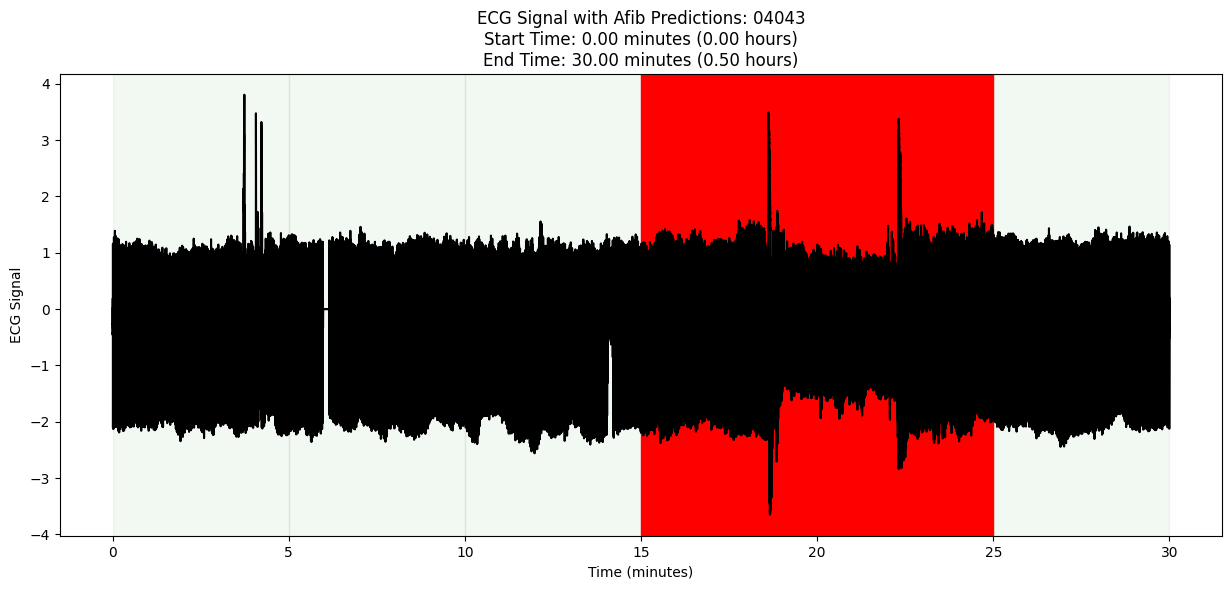

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


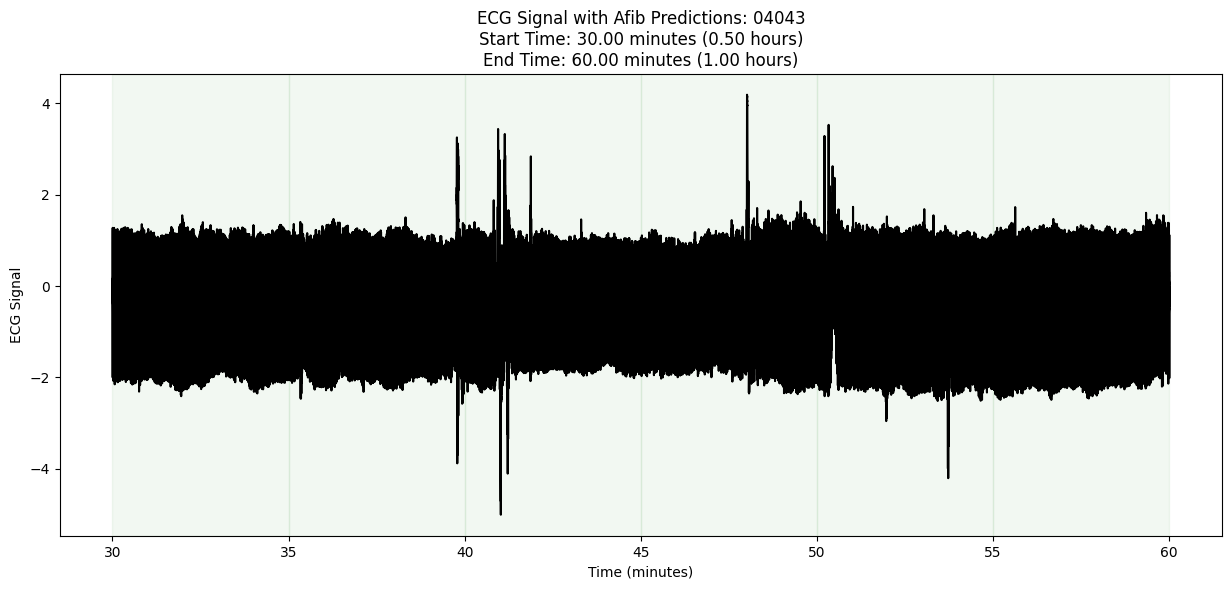

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


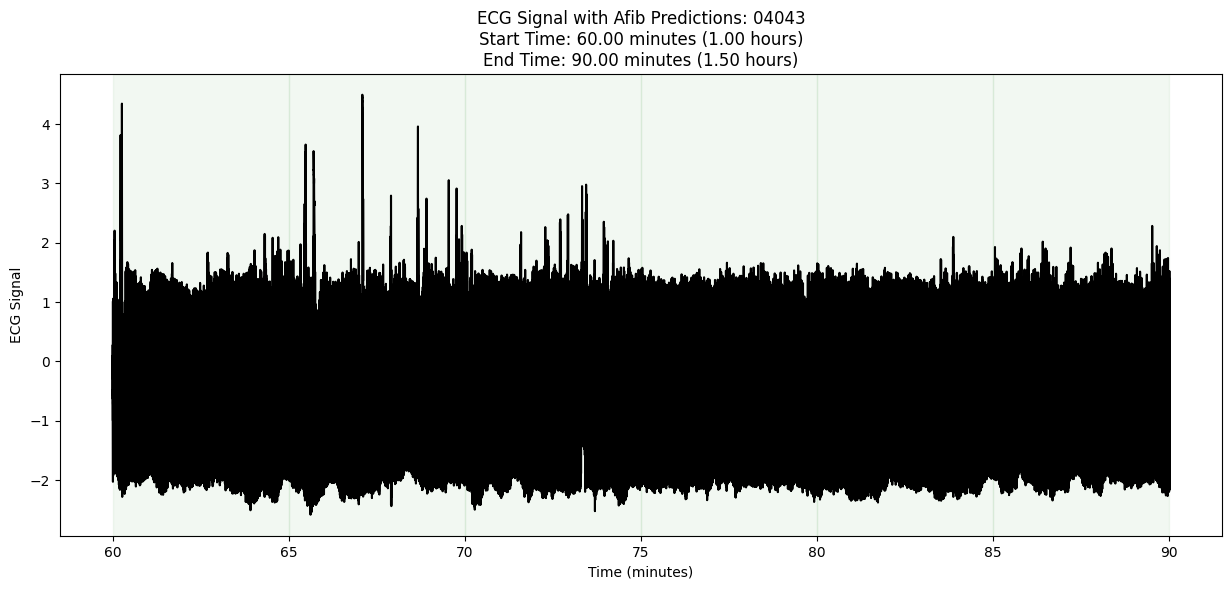

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


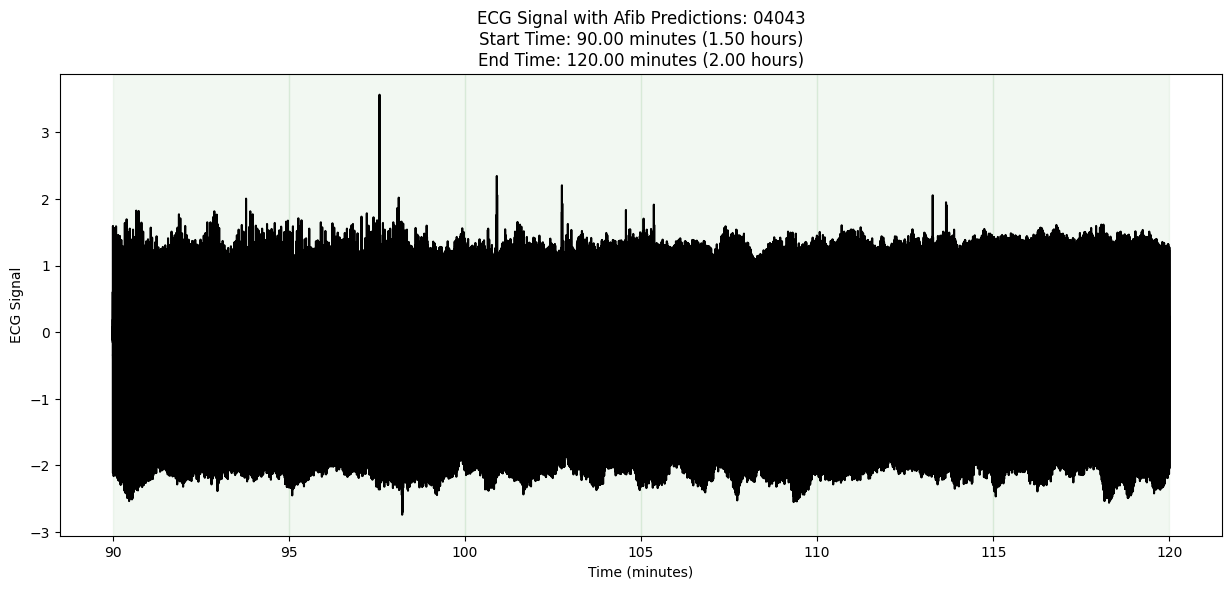

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


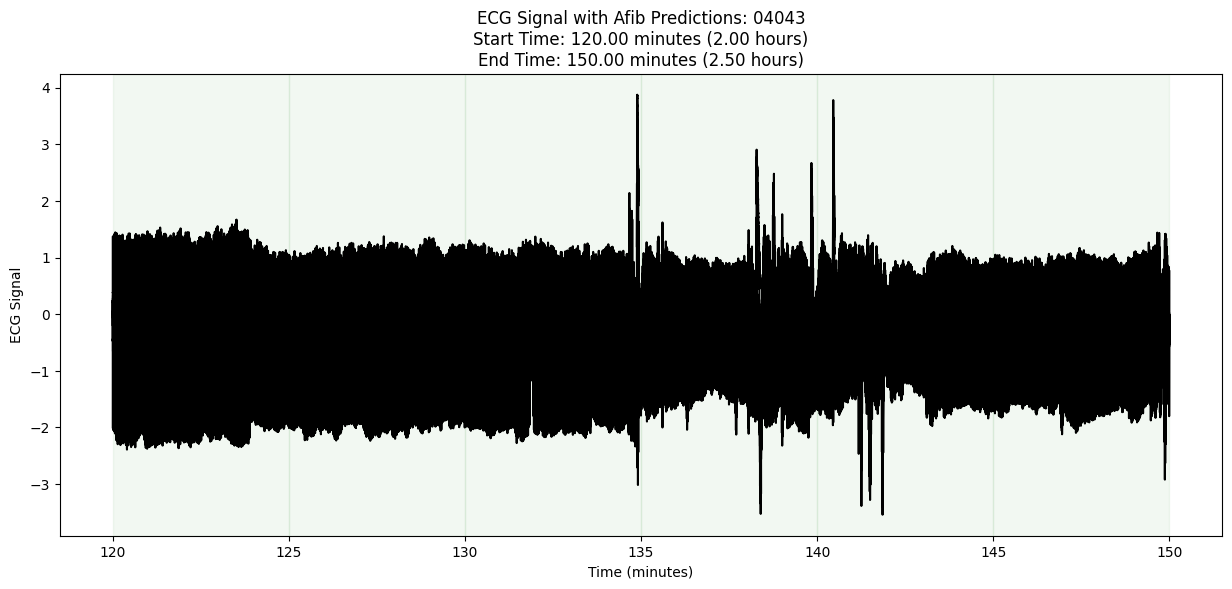

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


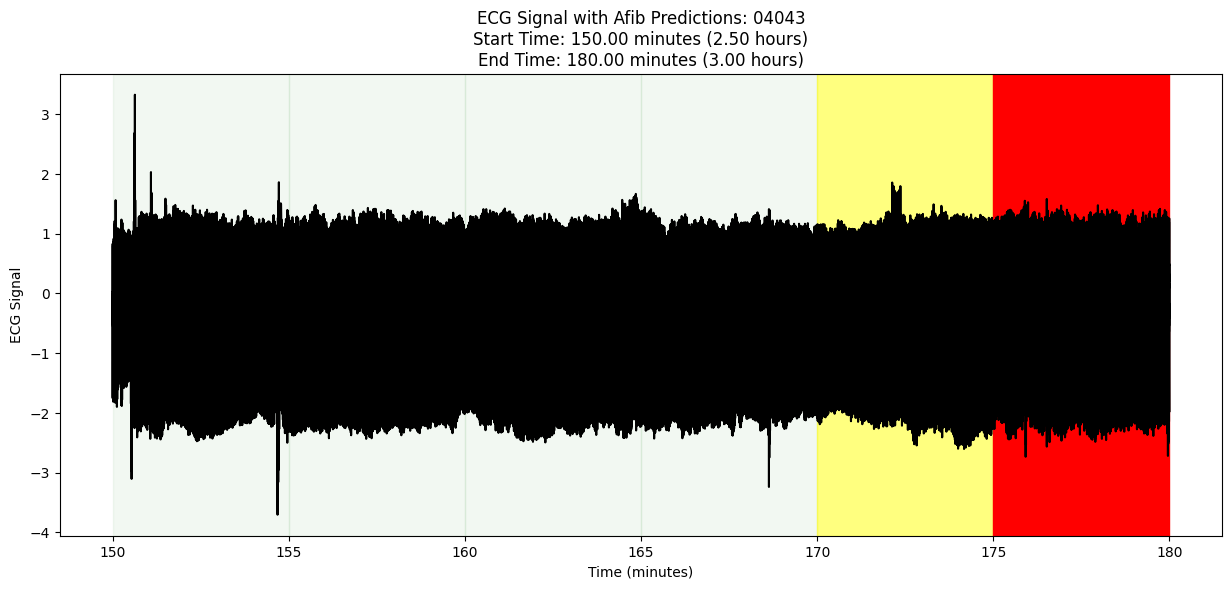

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


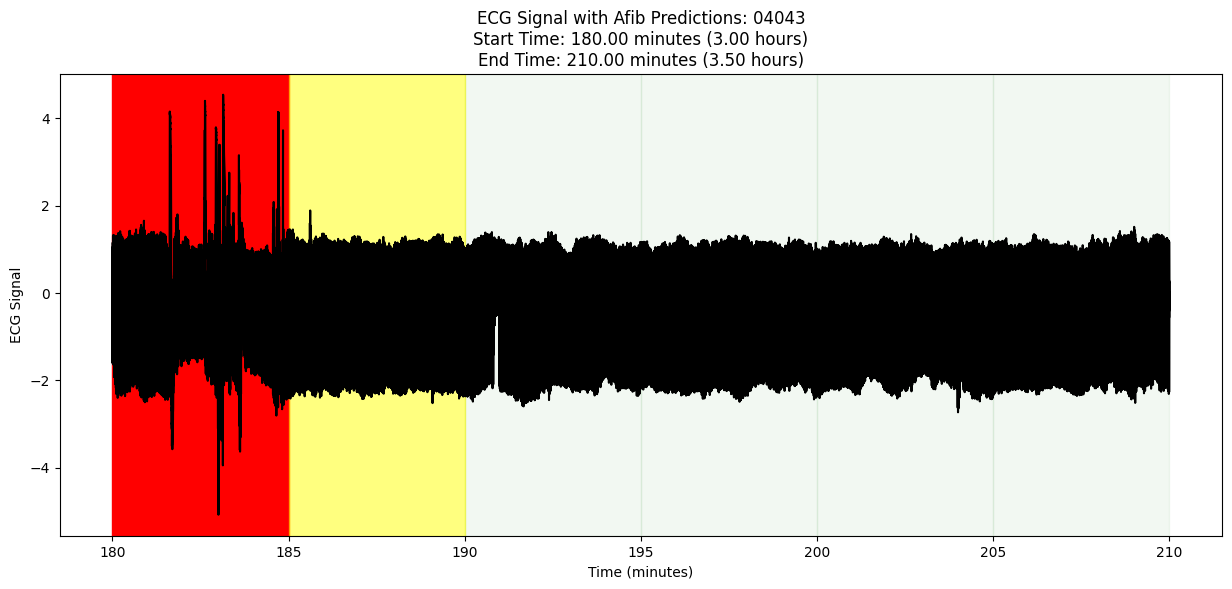

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


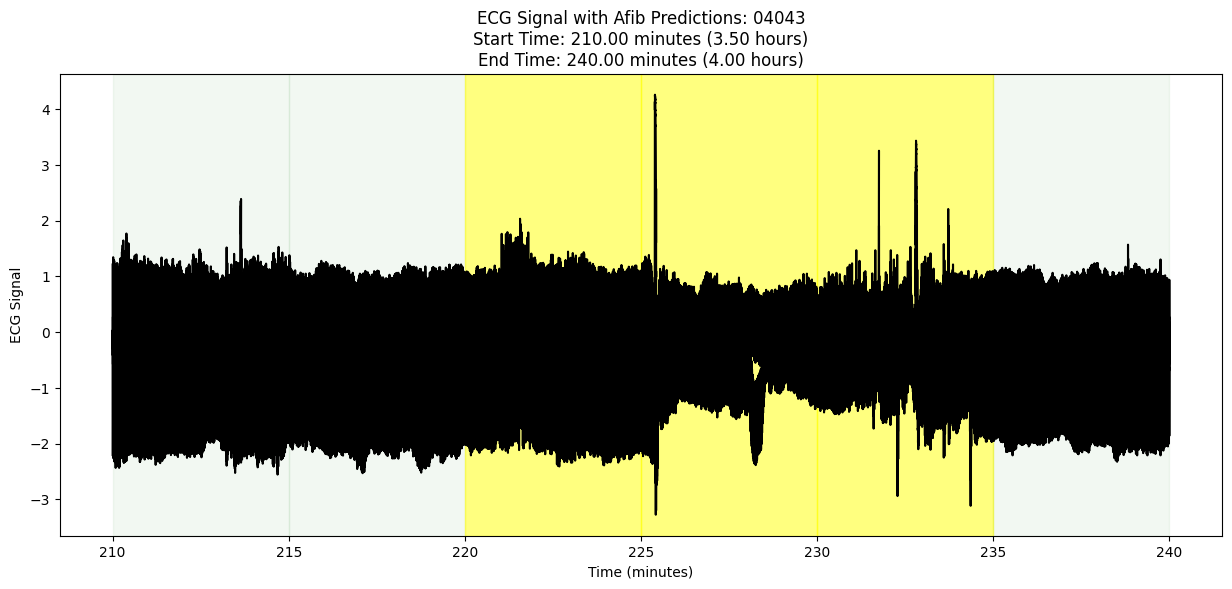

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


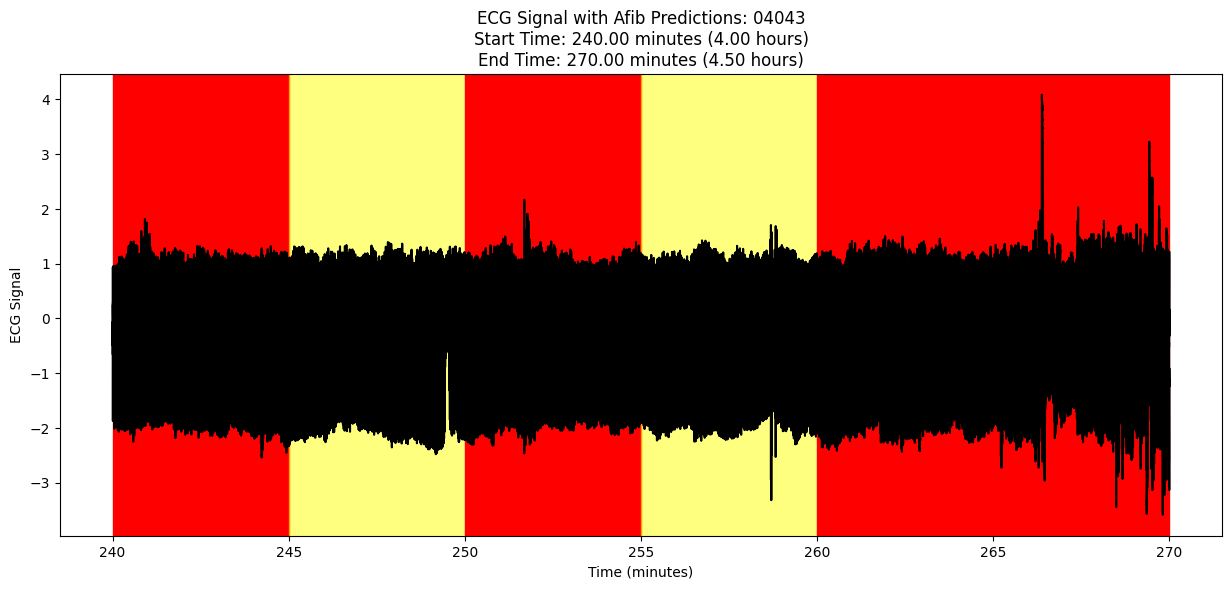

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


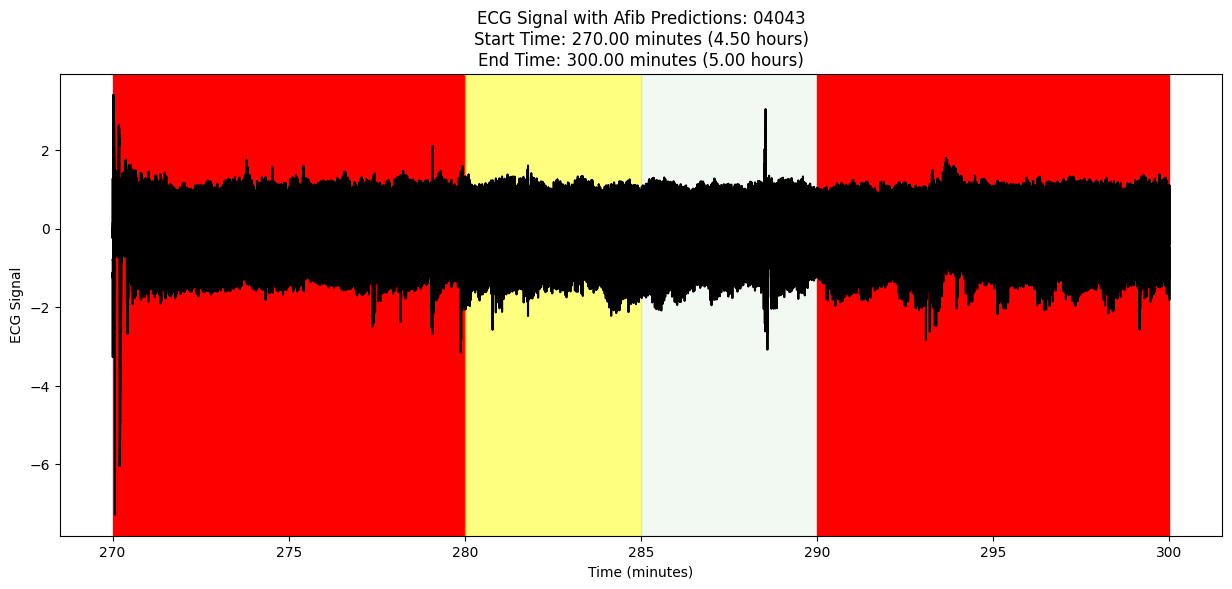

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


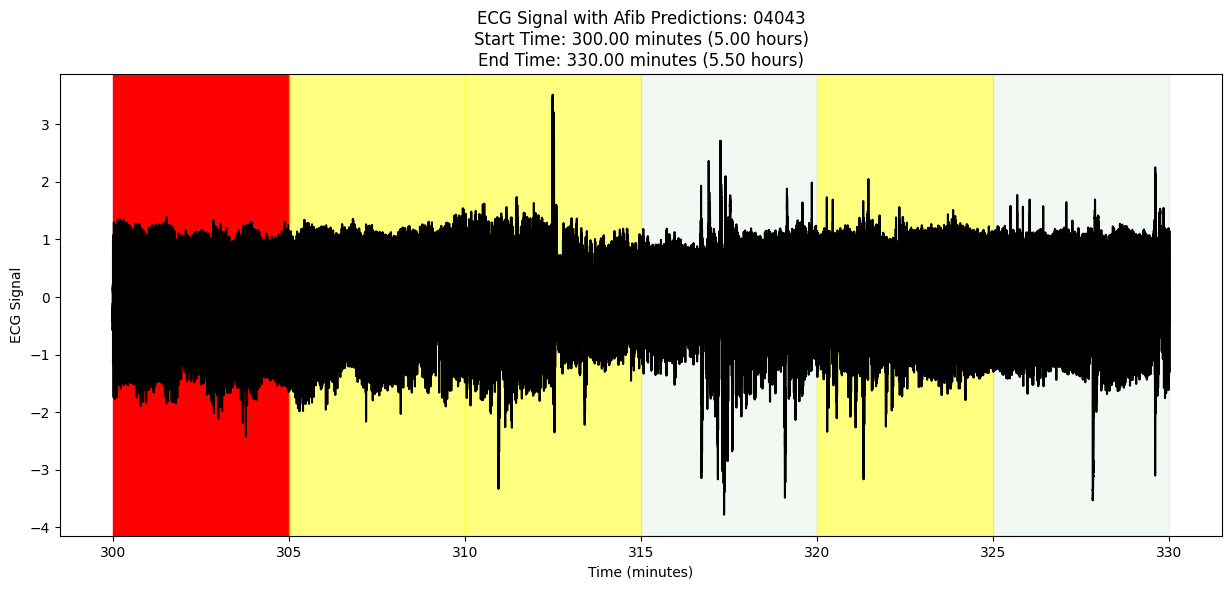

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


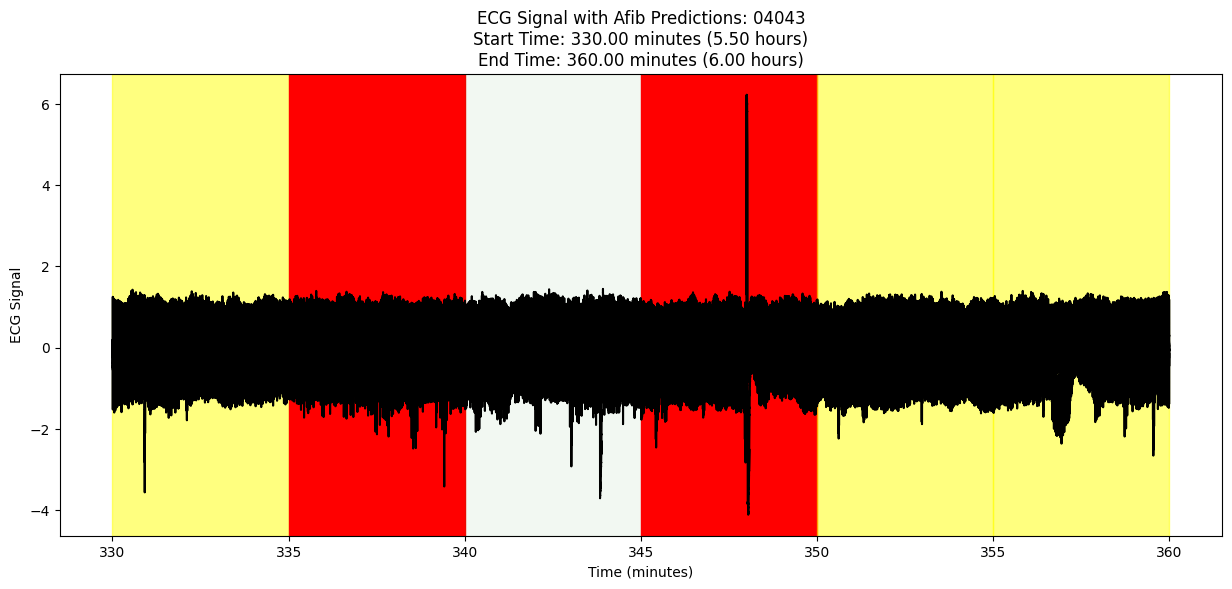

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


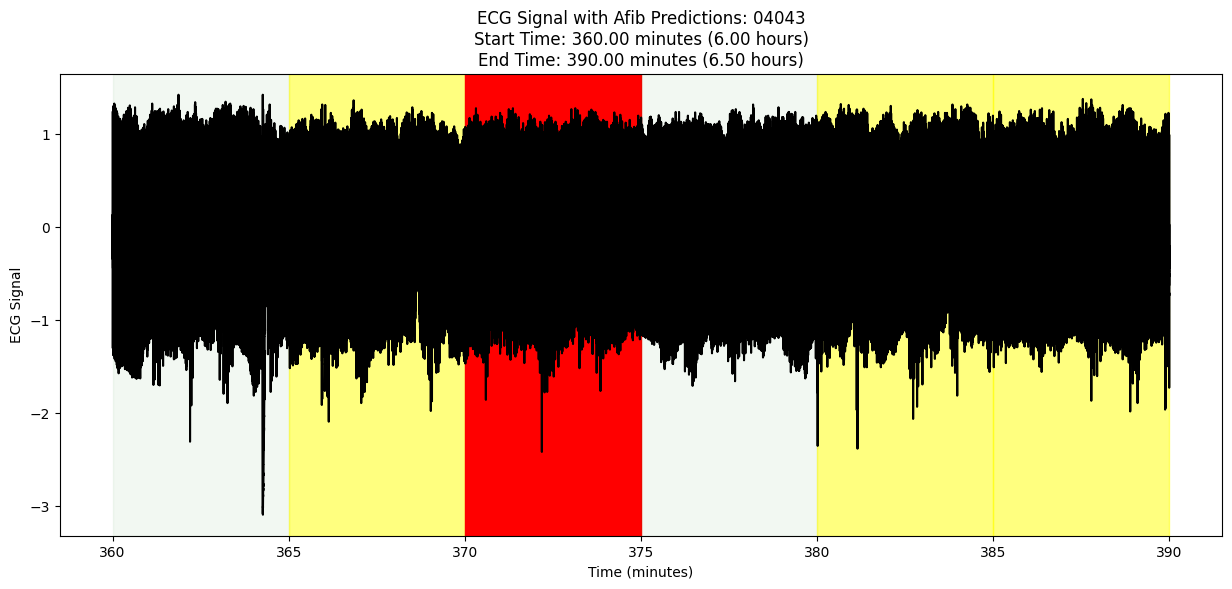

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


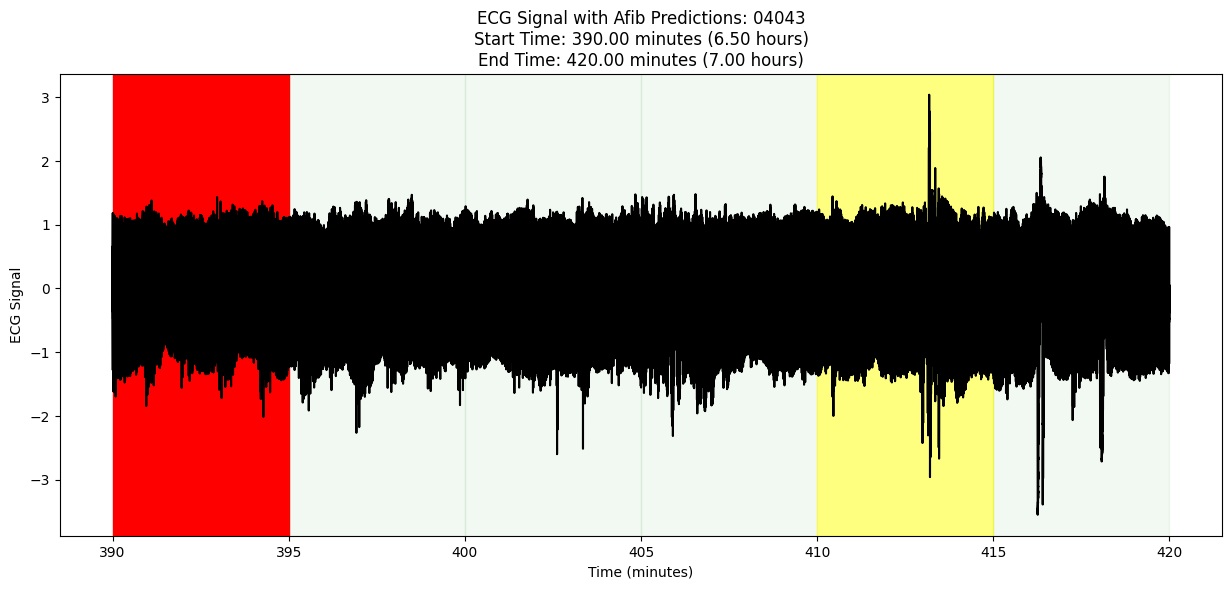

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


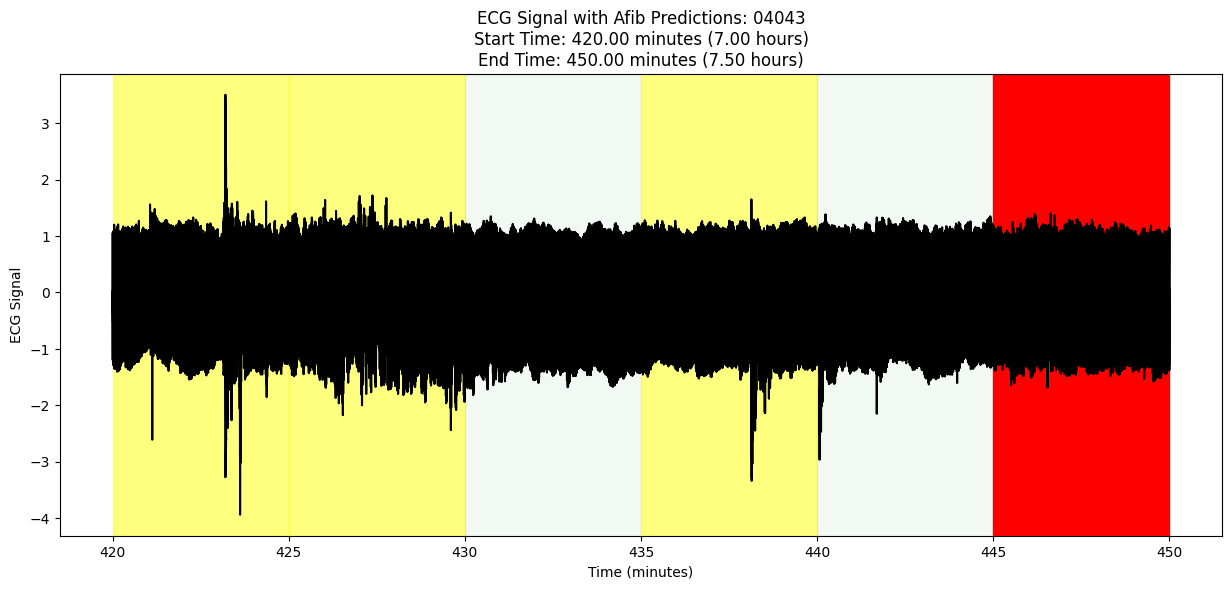

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


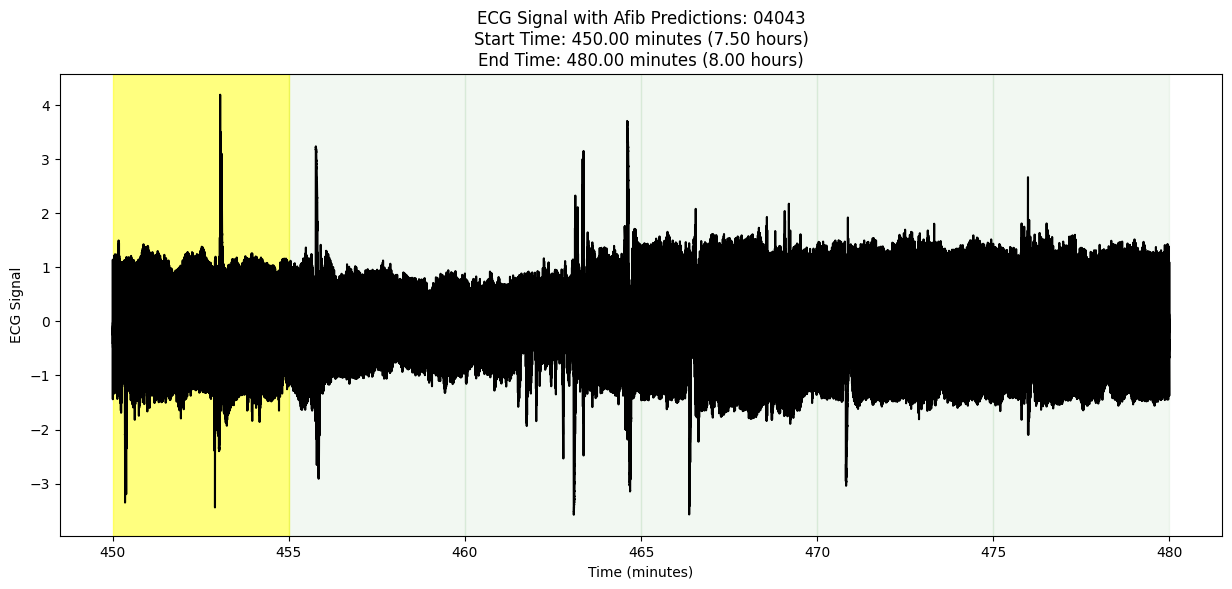

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


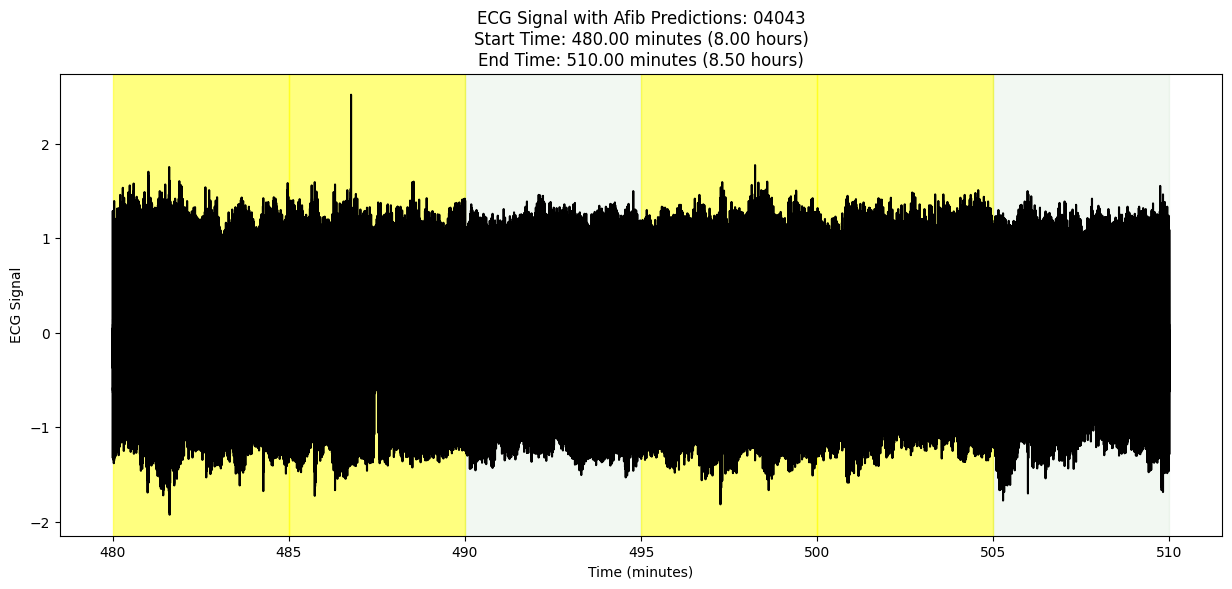

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


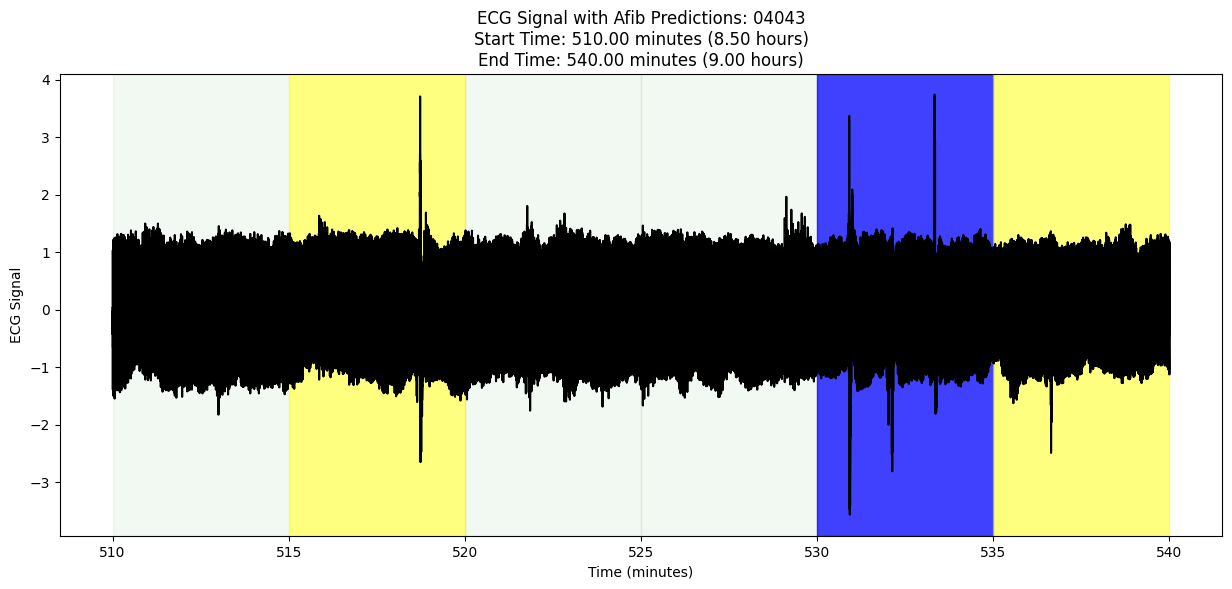

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


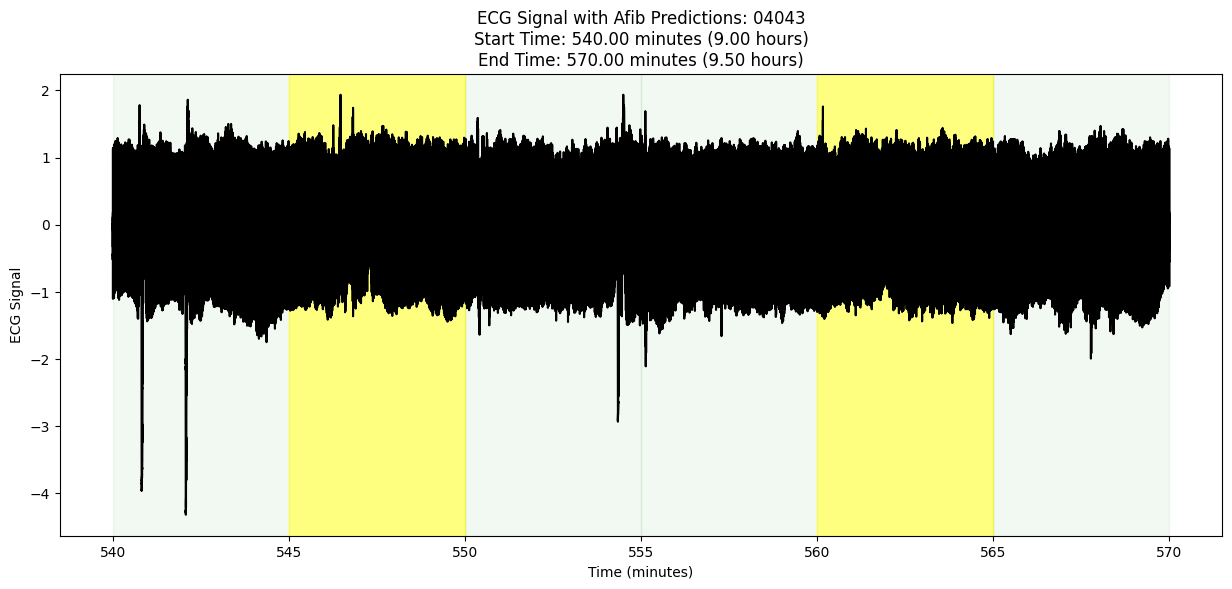

Predictions: 54
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 1 1 1 1 1 1 0]
Actual AFIB: 20
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


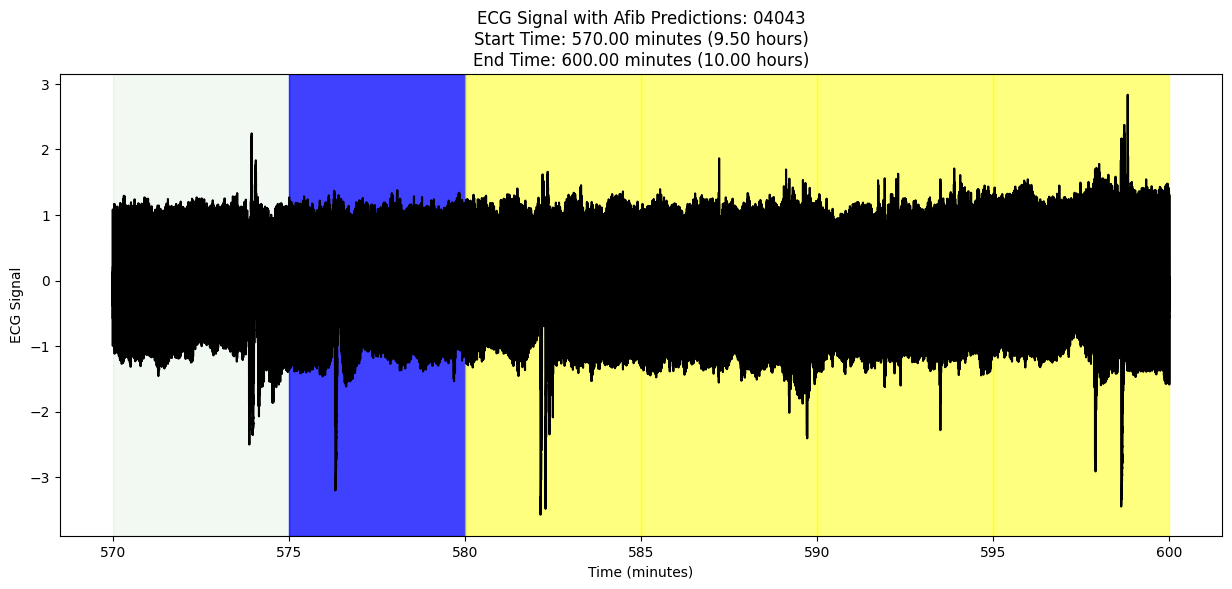

In [ ]:
actual_afib_annotations = extract_afib_annotations(features_list)
interval_length_minutes = 30
interval_length_seconds = interval_length_minutes * 60
total_duration_seconds = len(ecg_signal) / sampling_rate
num_intervals = int(total_duration_seconds / interval_length_seconds)

for i in range(num_intervals):
  start_time = i * interval_length_seconds
  end_time = (i + 1) * interval_length_seconds
  # Plot ECG with Afib predictions for each 30-minute interval
  plot_ecg_with_predictions(ecg_signal, predictions, actual_afib_annotations, sampling_rate, start_time, end_time)

1. Czerwony:
Oznacza przedziały czasowe, w których model przewidział AFib i rzeczywista adnotacja również potwierdza obecność AFib.
To oznacza poprawne pozytywne predykcje.


2. Żółty:
Oznacza przedziały, w których model przewidział AFib, ale rzeczywista adnotacja nie potwierdza AFib.
To są fałszywe pozytywy.


3. Niebieski:
Oznacza przedziały, w których rzeczywista adnotacja wskazuje AFib, ale model nie wykrył AFib.
To są fałszywe negatywy.


4. Zielony:
Oznacza przedziały, w których model nie przewidział AFib i rzeczywista adnotacja również nie wskazuje na obecność AFib.
To oznacza poprawne negatywne predykcje.